In [1]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]
#Changes to these correlations over 61 days
change = []
k_0 = 0.003
for i in range (0, 61):
    change.append(0.25*np.sin(k_0*i))    

In [2]:
#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,100), range(0,100)):
        x[k][i][j] = np.tanh(x[k][i][j])

def daily_correlation(sigma):
    daily_corr = np.zeros((61, 100, 100))
    for (i, j) in product (range(0,100), range(0,100)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10]+change[0], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j]-change[k-1]+
                                                                          change[k], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0
    tanh(daily_corr)   
    return daily_corr

daily_corr = daily_correlation(0.3)




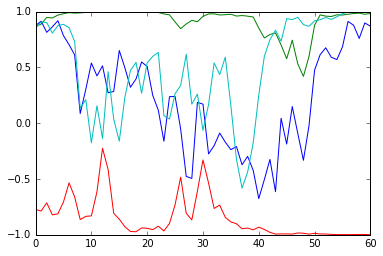

In [3]:
 #Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][97][95])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [4]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [5]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [6]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [7]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
N_samples = 1200
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 1000 - range_of_sample
        boundary1 = 1000
    if (sample_or_not=='out_of_sample'):
        boundary0 = 1000
        boundary1 = 1200
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

In [8]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


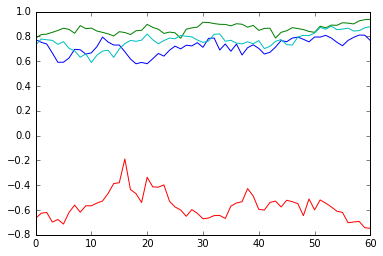

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\Mikhail\Anaconda2\lib\site-packages\scipy\optimize\slsqp.py:337: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


0:41:35.343000 [ 0.20557188  0.79442812] 0.0215861319544
0.0179192628499


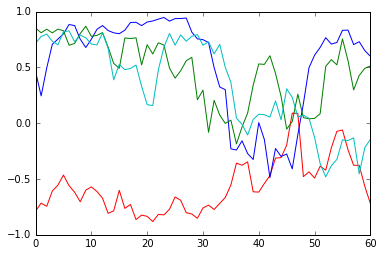

0:34:11.216000 [ 0.66777285  0.33220642] 0.0291326118071
0.0268818125918


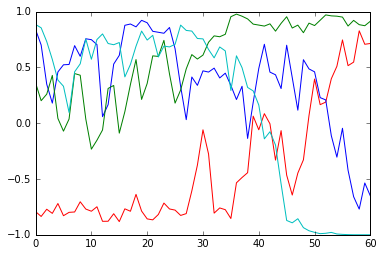

0:31:59.077000 [ 0.60121503  0.39878179] 0.0277432369302
0.0287142957262


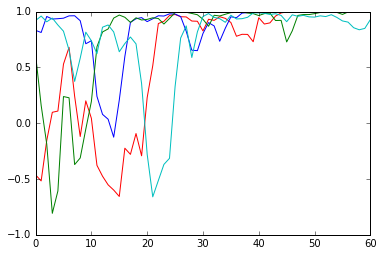

0:25:48.096000 [ 0.82467508  0.17532492] 0.0250501810677
0.0285020358369


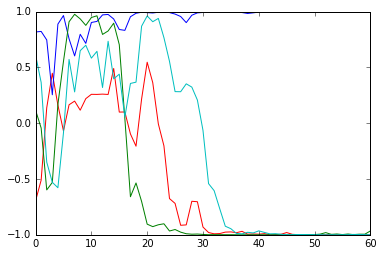

0:21:30.633000 [ 0.79865352  0.09893457] 0.0391349394327
0.0377265512278


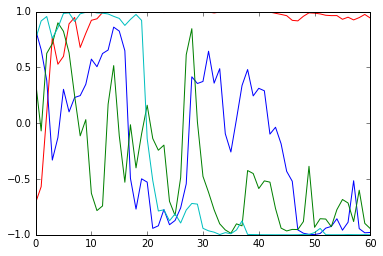

0:26:10.443000 [ 0.84136108  0.15863892] 0.0458330318044
0.0511041229439


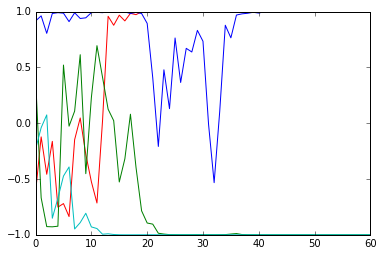

0:18:16.112000 [ 0.47957295  0.27674773] 0.035857210475
0.0316893082391


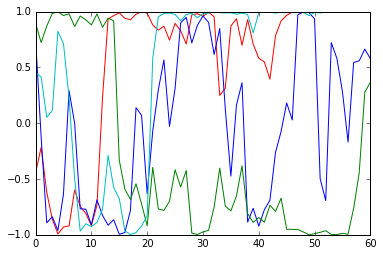

0:13:27.428000 [  1.00000000e+00  -5.55111512e-17] 0.0298609454201
0.0375743824204


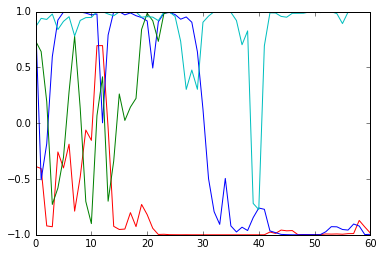

0:21:58.962000 [ 0.47249498  0.52750502] 0.0313215468297
0.0351595064932


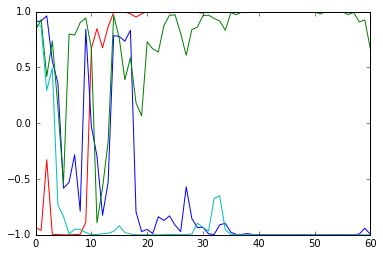

0:26:00.269000 [ 0.89228449  0.10771551] 0.0256947499044
0.0313843492178


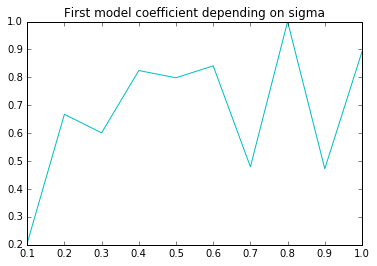

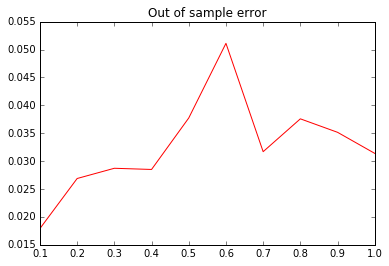

In [9]:
times = []
results = []
sample_error = []
out_of_sample_error = []
sigma_values = np.linspace(0.1, 1.0, 10)
for sigma in sigma_values:
    daily_corr = daily_correlation(sigma)
    plots(daily_corr)
    m0, m1, r1 = empiric_models(N_samples, daily_corr)
    time, result, err = optimal_model_weights(1000)
    sample_error.append(err)
    results.append([result[0], result[1], 1-result[0]-result[1]])
    times.append(time)
    print time, result, err
    e = error(result, 'out_of_sample', 100)
    print e
    out_of_sample_error.append(e)

a = []
for i in range(0,10):
    a.append(results[i][0])
    
plt.plot(sigma_values, a, 'c')
plt.title('First model coefficient depending on sigma')
plt.show()
 
#Graph showing evolution of error on the out_of_sample depending on the range_of_sample
plt.plot(sigma_values, out_of_sample_error, 'r')
plt.title('Out of sample error')
plt.show()

In [10]:
print times
print results
print sample_error
print out_of_sample_error


[datetime.timedelta(0, 2495, 343000), datetime.timedelta(0, 2051, 216000), datetime.timedelta(0, 1919, 77000), datetime.timedelta(0, 1548, 96000), datetime.timedelta(0, 1290, 633000), datetime.timedelta(0, 1570, 443000), datetime.timedelta(0, 1096, 112000), datetime.timedelta(0, 807, 428000), datetime.timedelta(0, 1318, 962000), datetime.timedelta(0, 1560, 269000)]
[[0.20557188424940109, 0.79442811575059891, 0.0], [0.66777285413113918, 0.3322064244706826, 2.0721398178213946e-05], [0.60121502790557435, 0.39878179434509764, 3.1777493280094049e-06], [0.82467508331348671, 0.1753249166865132, 8.3266726846886741e-17], [0.79865352247064236, 0.098934574011899548, 0.10241190351745809], [0.84136108147589617, 0.15863891852410389, -5.5511151231257827e-17], [0.47957294932953304, 0.27674772988875834, 0.24367932078170856], [0.99999999999999989, -5.5511151231257827e-17, 1.6653345369377348e-16], [0.47249498032564802, 0.52750501967435204, 0.0], [0.89228448608542454, 0.1077155139145755, -4.16333634234433

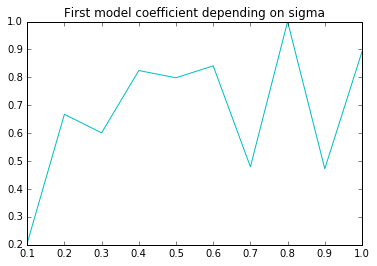

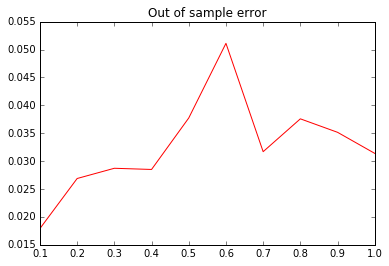

In [11]:

a = []
for i in range(0,10):
    a.append(results[i][0])
    
plt.plot(sigma_values, a, 'c')
plt.title('First model coefficient depending on sigma')
plt.show()
 
#Graph showing evolution of error on the out_of_sample depending on the range_of_sample
plt.plot(sigma_values, out_of_sample_error, 'r')
plt.title('Out of sample error')
plt.show()

In [12]:
print a

[0.20557188424940109, 0.66777285413113918, 0.60121502790557435, 0.82467508331348671, 0.79865352247064236, 0.84136108147589617, 0.47957294932953304, 0.99999999999999989, 0.47249498032564802, 0.89228448608542454]
